In [ ]:
# Additional Dependencies
!pip install barbar torchsummary

# Content Based Image Retrieval (CBIR)
## Approach:

- By observing the data its pretty clear that an Unsupervised alongwith couple of different Hashing approachs will be the most commendable. Although there are number of techniques in that area as well, we'll focus on Hashing and Auto-Encoder techniques:
    
    - ***Latent Feature Extraction***: In this technique we can find feature vectors for every image by creating hooks on a pre-trained network and extracting the vector from previous layers. Other technique devises the use of **AutoEncoders** where the Latent features can be extracted from Encoder itself. For the sake of this data we'll proceed with AutoEncoders. For the retrieval part we'll look into Euclidean based Search (O(NlogN)) and Hashing Based Approaches (O(logN)).
    <br>
    - ***Image Hashing Search***: This can be done by:
        - Uniquely quantify the contents of an image using only a single integer.
        - Find duplicate or near-duplicate images in a dataset of images based on their computed hashes.<br>
        <br>
      This can be accomplished by a specialized data structure called a **VP-Tree**. Using a VP-Tree we can reduce our search complexity from O(nlogn) to O(log n), enabling us to obtain our sub-linear goal!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import time
import copy
import pickle
from barbar import Bar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 0

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Find if any accelerator is presented, if yes switch device to use CUDA or else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
# preparing intermediate DataFrame
datasetPath = Path('/content/drive/MyDrive/Colab Notebooks/dataset_cbir/')
df = pd.DataFrame()

df['image'] = [f for f in os.listdir(datasetPath) if os.path.isfile(os.path.join(datasetPath, f))]
df['image'] = '/content/drive/MyDrive/Colab Notebooks/dataset_cbir/' + df['image'].astype(str)

df.head()

,image
0,/content/drive/MyDrive/Colab Notebooks/dataset...
1,/content/drive/MyDrive/Colab Notebooks/dataset...
2,/content/drive/MyDrive/Colab Notebooks/dataset...
3,/content/drive/MyDrive/Colab Notebooks/dataset...
4,/content/drive/MyDrive/Colab Notebooks/dataset...


# Data Preparation

In [ ]:
class CBIRDataset(Dataset):
    def __init__(self, dataFrame, img_size=(256, 256)):
        self.dataFrame = dataFrame

        self.transformations = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')

        row = self.dataFrame.iloc[key]
        image = self.transformations(Image.open(row['image']))
        return image

    def __len__(self):
        return len(self.dataFrame.index)

In [ ]:
# Intermediate Function to process data from the data retrival class
def prepare_data(DF):
    trainDF, validateDF = train_test_split(DF, test_size=0.15, random_state=RANDOMSTATE)
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)

    return train_set, validate_set

# AutoEncoder Model

## High Level Structure of an AutoEncoder

![](https://hackernoon.com/hn-images/1*op0VO_QK4vMtCnXtmigDhA.png)

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)

            nn.Conv2d(in_channels=3,
                      out_channels=16,
                      kernel_size=(3,3),
                      stride=3,
                      padding=1),  # (32,16,171,171)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (N,16,85,85)

            nn.Conv2d(in_channels=16,
                      out_channels=8,
                      kernel_size=(3,3),
                      stride=2,
                      padding=1),  # (N,8,43,43)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (N,8,42,42)
        )
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(in_channels = 8,
                               out_channels=16,
                               kernel_size=(3,3),
                               stride=2),  # (N,16,85,85)
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=16,
                               out_channels=8,
                               kernel_size=(5,5),
                               stride=3,
                               padding=1),  # (N,8,255,255)
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=8,
                               out_channels=3,
                               kernel_size=(6,6),
                               stride=2,
                               padding=1),  # (N,3,512,512)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class ConvAutoencoder_v2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder_v2, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)

            nn.Conv2d(in_channels=3,
                      out_channels=64,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64,
                      out_channels=64,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=(3,3),
                      stride=2,
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=(3,3),
                      stride=1,
                      padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=(3,3),
                      stride=2,
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=(3,3),
                      stride=1,
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(in_channels = 256,
                               out_channels=256,
                               kernel_size=(3,3),
                               stride=1,
                              padding=1),

            nn.ConvTranspose2d(in_channels=256,
                               out_channels=256,
                               kernel_size=(3,3),
                               stride=1,
                               padding=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=(3,3),
                               stride=2,
                               padding=0),

            nn.ConvTranspose2d(in_channels=128,
                               out_channels=64,
                               kernel_size=(3,3),
                               stride=2,
                               padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64,
                               out_channels=32,
                               kernel_size=(3,3),
                               stride=2,
                               padding=1),

            nn.ConvTranspose2d(in_channels=32,
                               out_channels=32,
                               kernel_size=(3,3),
                               stride=2,
                               padding=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=32,
                               out_channels=3,
                               kernel_size=(4,4),
                               stride=2,
                               padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
summary(ConvAutoencoder_v2().to(device),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 126, 126]         147,584
              ReLU-9        [-1, 128, 126, 126]               0
        MaxPool2d-10          [-1, 128, 63, 63]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

# Training Function

In [ ]:
def load_ckpt(checkpoint_fpath, model, optimizer):

    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # initialize valid_loss_min from checkpoint to valid_loss_min
    #valid_loss_min = checkpoint['valid_loss_min']

    # return model, optimizer, epoch value, min validation loss
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best")
    torch.save(state, filename)  # save checkpoint

def train_model(model,
                criterion,
                optimizer,
                #scheduler,
                num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for idx,inputs in enumerate(Bar(dataloaders[phase])):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={
                                    'epoch': epoch,
                                    'state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                },filename='ckpt_epoch_{}.pt'.format(epoch))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss

In [ ]:
EPOCHS = 20
NUM_BATCHES = 32
RETRAIN = False

train_set, validate_set = prepare_data(DF=df)

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, num_workers=1) ,
                'val':DataLoader(validate_set, batch_size=NUM_BATCHES, num_workers=1)
                }

dataset_sizes = {'train': len(train_set),'val':len(validate_set)}

model = ConvAutoencoder_v2().to(device)

criterion = nn.MSELoss()
# Observe that all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
# If re-training is required:
# Load the old model
if RETRAIN == True:
    # load the saved checkpoint
    model, optimizer, start_epoch = load_ckpt('/content/drive/MyDrive/Colab Notebooks/conv_autoencoder1.pt', model, optimizer)
    print('Checkpoint Loaded')

In [ ]:
model, optimizer, loss = train_model(model=model,
                    criterion=criterion,
                    optimizer=optimizer,
                    #scheduler=exp_lr_scheduler,
                    num_epochs=EPOCHS)

Epoch 0/20
----------
1168/1168: [===============================>] - ETA 22.2s
train Loss: 0.3909
207/207: [===========================>....] - ETA 1.0s
val Loss: 0.2559
=> Saving a new best

Epoch 1/20
----------
1168/1168: [===============================>] - ETA 0.5s
train Loss: 0.2111
207/207: [===========================>....] - ETA 0.5s
val Loss: 0.1603
=> Saving a new best

Epoch 2/20
----------
1168/1168: [===============================>] - ETA 0.6s
train Loss: 0.1428
207/207: [===========================>....] - ETA 0.5s
val Loss: 0.1321
=> Saving a new best

Epoch 3/20
----------
1168/1168: [===============================>] - ETA 0.8s
train Loss: 0.1292
207/207: [===========================>....] - ETA 0.4s
val Loss: 0.1274
=> Saving a new best

Epoch 4/20
----------
1168/1168: [===============================>] - ETA 0.5s
train Loss: 0.1241
207/207: [===========================>....] - ETA 0.4s
val Loss: 0.1235
=> Saving a new best

Epoch 5/20
----------
1168/1168: [=====

In [ ]:
# Save the Trained Model
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/Colab Notebooks/conv_autoencoderv2_200ep_3.pt')

# Inference

## 1. Indexing

In [ ]:
transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [ ]:
# Load Model in Evaluation phase
model = ConvAutoencoder_v2().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/conv_autoencoderv2_200ep_3.pt', map_location=device)['model_state_dict'], strict=False)

model.eval()

ConvAutoencoder_v2(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

In [ ]:
def get_latent_features(images, transformations, target_size=(256,256)):
    features_list = []

    for image_path in tqdm(images):
        try:
            # mở ảnh an toàn
            img = Image.open(image_path).convert("RGB")
            img = img.resize(target_size)

            # transform + đưa vào model
            tensor = transformations(img).unsqueeze(0).to(device)
            with torch.no_grad():
                latent = model.encoder(tensor)

            latent_np = latent.cpu().detach().numpy().squeeze(0)

            # chỉ thêm nếu có shape nhất quán
            features_list.append(latent_np)

            # giải phóng
            del tensor, latent, latent_np, img
            torch.cuda.empty_cache()
        except Exception as e:
            # nếu ảnh lỗi thì bỏ qua
            print(f"Bỏ ảnh lỗi: {image_path} ({e})")
            continue

    # nếu tất cả latent cùng shape
    latent_features = np.stack(features_list, axis=0)
    return latent_features

In [ ]:
images = df.image.values
latent_features = get_latent_features(images, transformations)

100%|██████████| 1375/1375 [00:19<00:00, 69.65it/s]


In [ ]:
indexes = list(range(0, 4738))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

In [ ]:
# write the data dictionary to disk
# with open('features.pkl', "wb") as f:
#    f.write(pickle.dumps(index_dict))

## 2. Image Retrieval

<font size="3"> This will be approached with two ways as discussed in the start:
    - Euclidean Search:
        - Identifying the Latent Features
        - Calculating the Euclidean Distance between them
        - Returning the closest N indexes (of images)
    
    - Locality Sensitive Hashing
        - Create hashes of the feature vector from Encoder
        - Store it in a Hashing Table
        - Identify closest images based on hamming distance

### 2.1 Euclidean Search Method

In [ ]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [ ]:
def cosine_distance(a,b):
    return scipy.spatial.distance.cosine(a, b)

In [ ]:
# def perform_search(queryFeatures, index, maxResults=64):

#     results = []

#     for i in range(0, len(index["features"])):
#         # compute the euclidean distance between our query features
#         # and the features for the current image in our index, then
#         # update our results list with a 2-tuple consisting of the
#         # computed distance and the index of the image
#         d = euclidean(queryFeatures, index["features"][i])
#         results.append((d, i))

#     # sort the results and grab the top ones
#     results = sorted(results)[:maxResults]
#     # return the list of results
#     return results

def perform_search(queryFeatures, index, threshold=0.7):
    results = []

    distances = []
    for i in range(len(index["features"])):
        d = euclidean(queryFeatures, index["features"][i])
        distances.append((d, i))

    max_d = max([d for d, _ in distances]) if distances else 1.0

    for d, i in distances:
        sim = 1 - (d / max_d)
        if sim >= threshold:   
            results.append((sim, i))

    results = sorted(results, key=lambda x: x[0], reverse=True)

    return results


In [ ]:
def build_montages(image_list, image_shape, montage_shape):

    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

500
483
506
504
1157
1122
1207
1268
1339
311
1204
187
1216
1175
962
1295
917
1158
821
498
960
771
368
566
473
387
439
494
1221
505
408
1287
584
1248
572
509
453
490


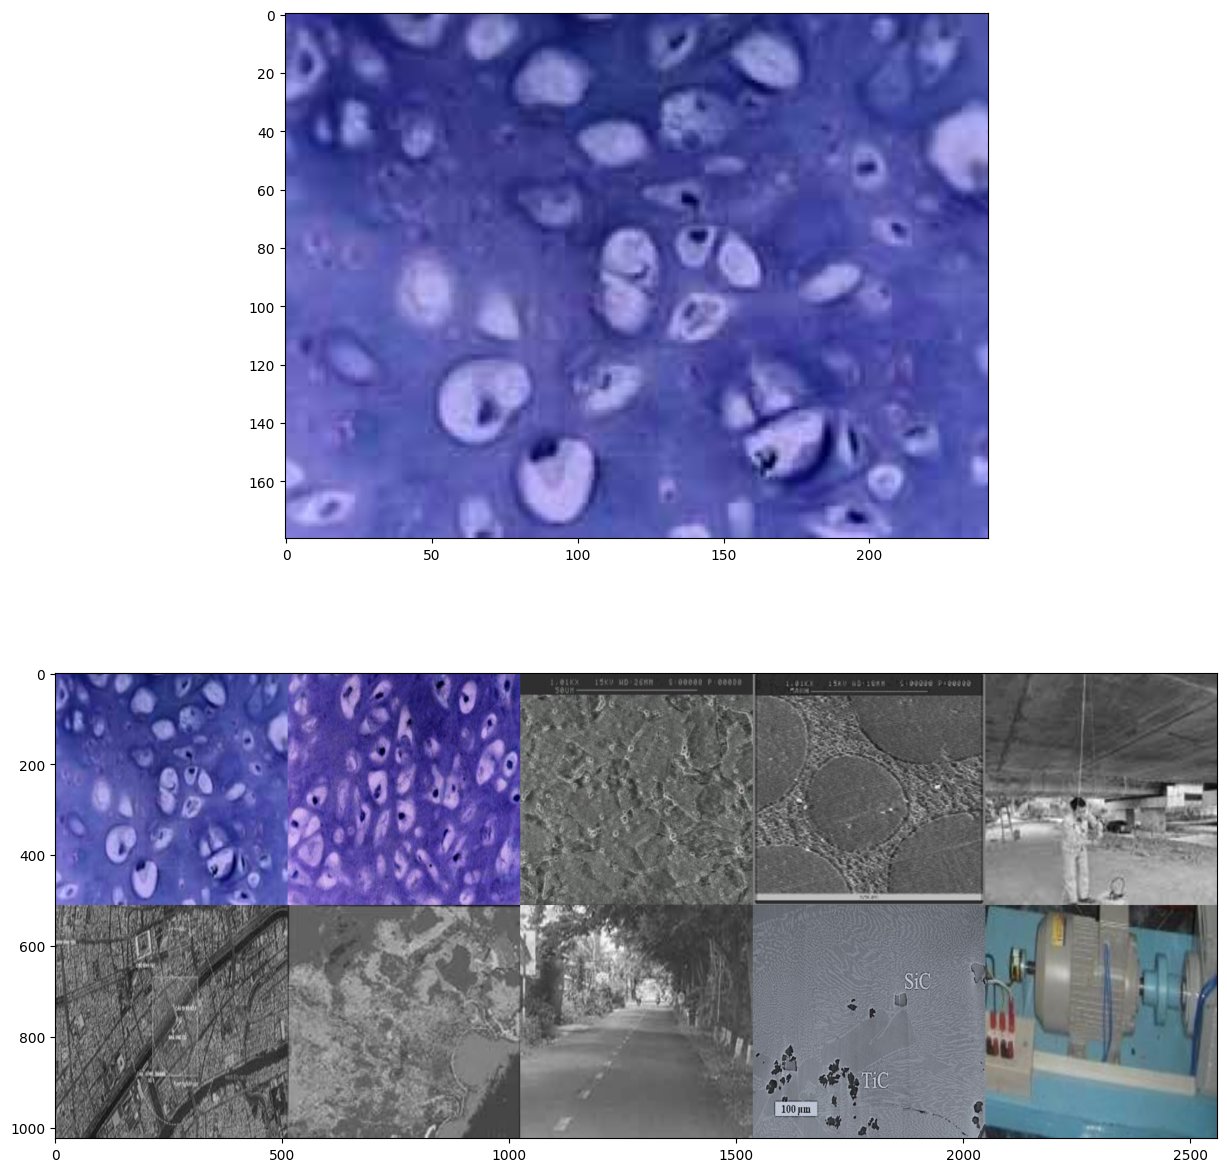

In [ ]:
# take the features for the current image, find all similar
# images in our dataset, and then initialize our list of result
# images
images = df.image.values
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
queryIdx = 500 # Input Index for which images

queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, 0.8)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j)
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(images[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

In [ ]:
testpath = Path('/content/drive/MyDrive/Colab Notebooks/test_img')
testdf = pd.DataFrame()

testdf['image'] = [f for f in os.listdir(testpath) if os.path.isfile(os.path.join(testpath, f))]
testdf['image'] = '/content/drive/MyDrive/Colab Notebooks/test_img/' + testdf['image'].astype(str)

testdf.head()

,image
0,/content/drive/MyDrive/Colab Notebooks/test_im...
1,/content/drive/MyDrive/Colab Notebooks/test_im...
2,/content/drive/MyDrive/Colab Notebooks/test_im...
3,/content/drive/MyDrive/Colab Notebooks/test_im...
4,/content/drive/MyDrive/Colab Notebooks/test_im...


In [ ]:
testimages = testdf.image.values
test_latent_features = get_latent_features(testimages, transformations)

100%|██████████| 19/19 [00:02<00:00,  7.91it/s]


In [ ]:
test_latent_features.shape

(19, 256, 8, 8)

In [ ]:
# Tạo index từ test_img
index_dict_test = {
    "features": test_latent_features,
    "filenames": testimages
}

16


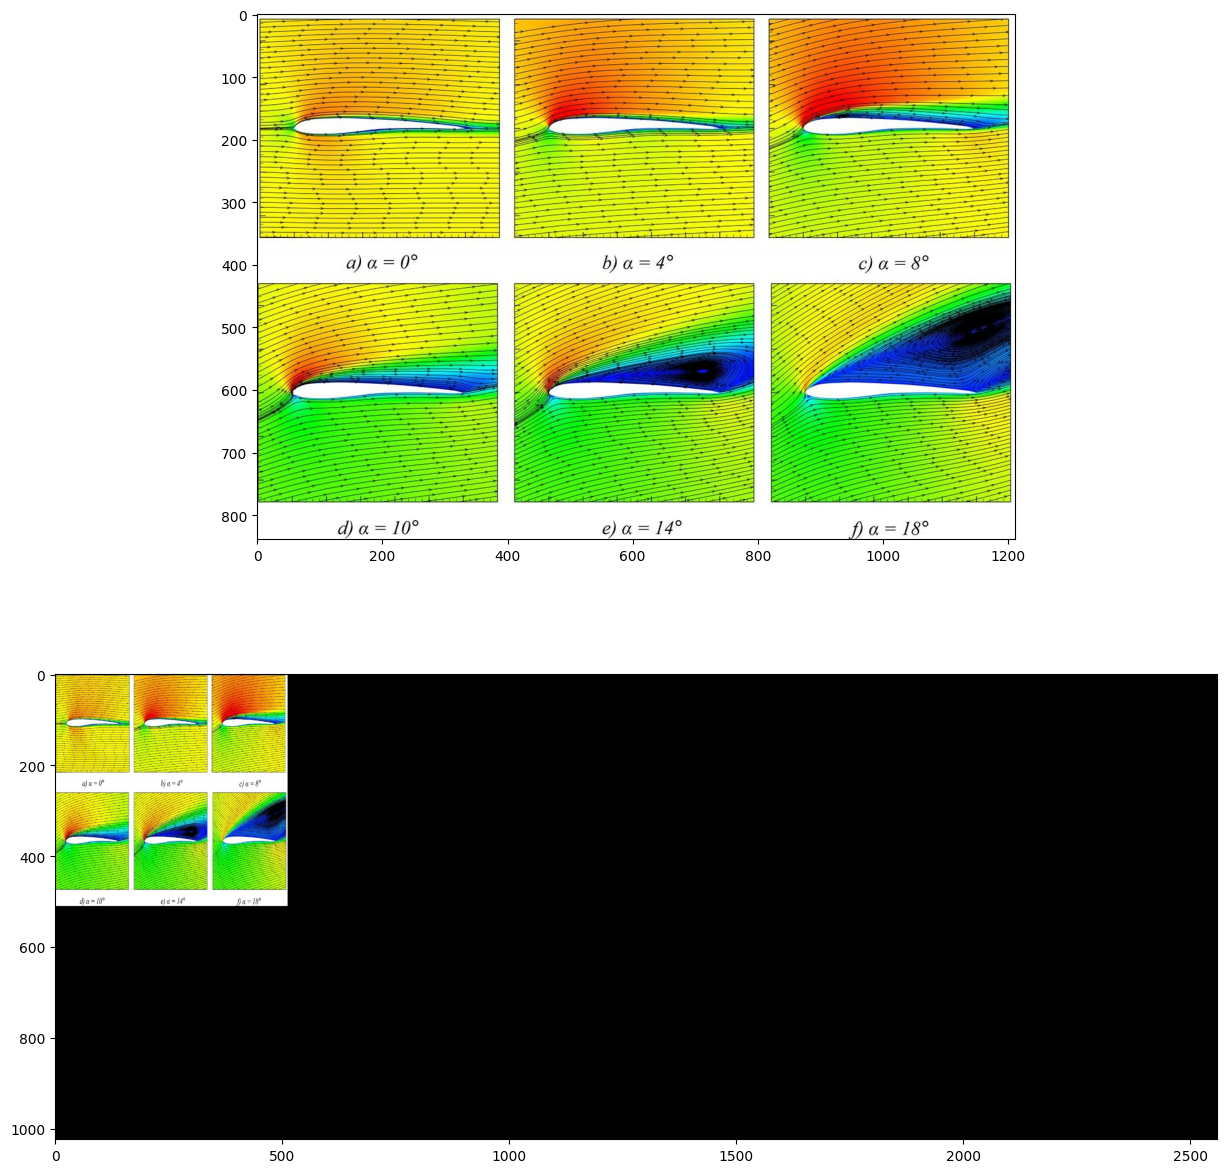

In [ ]:
# test truy vấn trên tập ảnh test
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
queryIdx = 16

queryFeatures = test_latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict_test, 0.7)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(testimages[j]))
    print(j)
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(testimages[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)

### 2.2 LSHashing Method

In [ ]:
#!pip install lshashpy3

In [ ]:
#from lshashpy3 import LSHash

In [ ]:
## Locality Sensitive Hashing
# params
# k = 12 # hash size
# L = 5  # number of tables
# d = 14112 # Dimension of Feature vector
# lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# # LSH on all the images
# for idx,vec in tqdm(feature_dict.items()):
#     lsh.index(vec.flatten(), extra_data=idx)

In [ ]:
## Exporting as pickle
#pickle.dump(lsh, open('lsh.p', "wb"))

In [ ]:
# def get_similar_item(idx, feature_dict, lsh_variable, n_items=10):
#     response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(),
#                      num_results=n_items+1, distance_func='hamming')

#     imgs = []
#     for i in range(1, n_items+1):
#         imgs.append(np.array(Image.open(images[response[i][0][1]])))
#     return imgs

In [ ]:
# fig, ax = plt.subplots(nrows=2,figsize=(15,15))
# queryIdx = 5

# ax[0].imshow(np.array(Image.open(images[queryIdx])))

# montage = build_montages(get_similar_item(queryIdx, feature_dict, lsh,10),(512, 512), (5, 2))[0]
# ax[1].imshow(montage)

# End Notes

- We started with the approach of AutoEncoders for Image Latent Features extraction followed by Image retrieval using Euclidean Distance which was an O(NlogN) approach (Time-Complexity) to Hashing which gave us an ~O(logN) approach

- Another approach was to use Hashing on features obtained from SIFT, SURF, OBS and building the VP Trees ans search the images in it.

![](https://www.pyimagesearch.com/wp-content/uploads/2019/08/image_hashing_search_engine_steps.png)

# Clustering of Images

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
%matplotlib inline

In [ ]:
def get_latent_features1D(images, transformations, target_size=(256, 256)):
    features_list = []

    for image_path in tqdm(images):
        try:
            # mở ảnh an toàn
            img = Image.open(image_path).convert("RGB")
            img = img.resize(target_size)

            # transform + đưa vào model
            tensor = transformations(img).unsqueeze(0).to(device)
            with torch.no_grad():
                latent = model.encoder(tensor)

            # chuyển sang numpy và flatten thành 1D
            latent_np = latent.cpu().detach().numpy().squeeze(0).flatten()

            # chỉ thêm nếu có shape nhất quán
            features_list.append(latent_np)

            # giải phóng
            del tensor, latent, latent_np, img
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"Bỏ ảnh lỗi: {image_path} ({e})")
            continue

    # nếu tất cả latent cùng shape 1D
    latent_features = np.stack(features_list, axis=0)
    return latent_features


In [ ]:
from PIL import Image

# Lọc ảnh có kích thước tối thiểu (ví dụ 64x64)
MIN_SIZE = 64

valid_images = []
for path in df.image.values:
    try:
        with Image.open(path) as img:
            w, h = img.size
            if w >= MIN_SIZE and h >= MIN_SIZE:
                valid_images.append(path)
    except:
        # nếu ảnh lỗi/không mở được thì bỏ qua
        pass

latent_features1d = get_latent_features1D(valid_images, transformations)

100%|██████████| 279/279 [00:12<00:00, 22.92it/s]


In [ ]:
latent_features1d = np.array(latent_features1d)

In [ ]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(4,10)

for k in tqdm(K):
    #Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(latent_features1d)

    distortions.append(sum(np.min(cdist(latent_features1d, kmeanModel.cluster_centers_,
                      'euclidean'),axis=1)) / latent_features1d.shape[0])
    inertias.append(kmeanModel.inertia_)

    mapping1[k] = sum(np.min(cdist(latent_features1d, kmeanModel.cluster_centers_,
                 'euclidean'),axis=1)) / latent_features1d.shape[0]
    mapping2[k] = kmeanModel.inertia_

100%|██████████| 6/6 [00:01<00:00,  4.94it/s]


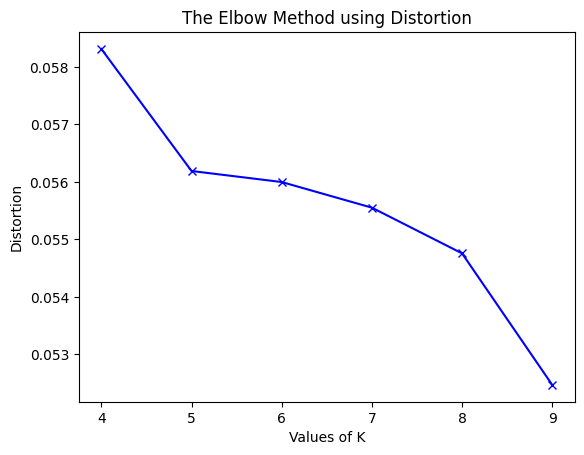

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

For n_clusters = 3 The average silhouette_score is : 0.37893748


 29%|██▊       | 2/7 [00:01<00:02,  1.68it/s]

For n_clusters = 4 The average silhouette_score is : 0.45525238


 43%|████▎     | 3/7 [00:01<00:02,  1.88it/s]

For n_clusters = 5 The average silhouette_score is : 0.36952853


 57%|█████▋    | 4/7 [00:02<00:01,  1.93it/s]

For n_clusters = 6 The average silhouette_score is : 0.35207146


 71%|███████▏  | 5/7 [00:02<00:01,  1.92it/s]

For n_clusters = 7 The average silhouette_score is : 0.28500837


 86%|████████▌ | 6/7 [00:03<00:00,  1.94it/s]

For n_clusters = 8 The average silhouette_score is : 0.225624
For n_clusters = 9 The average silhouette_score is : 0.22465542


100%|██████████| 7/7 [00:03<00:00,  1.85it/s]


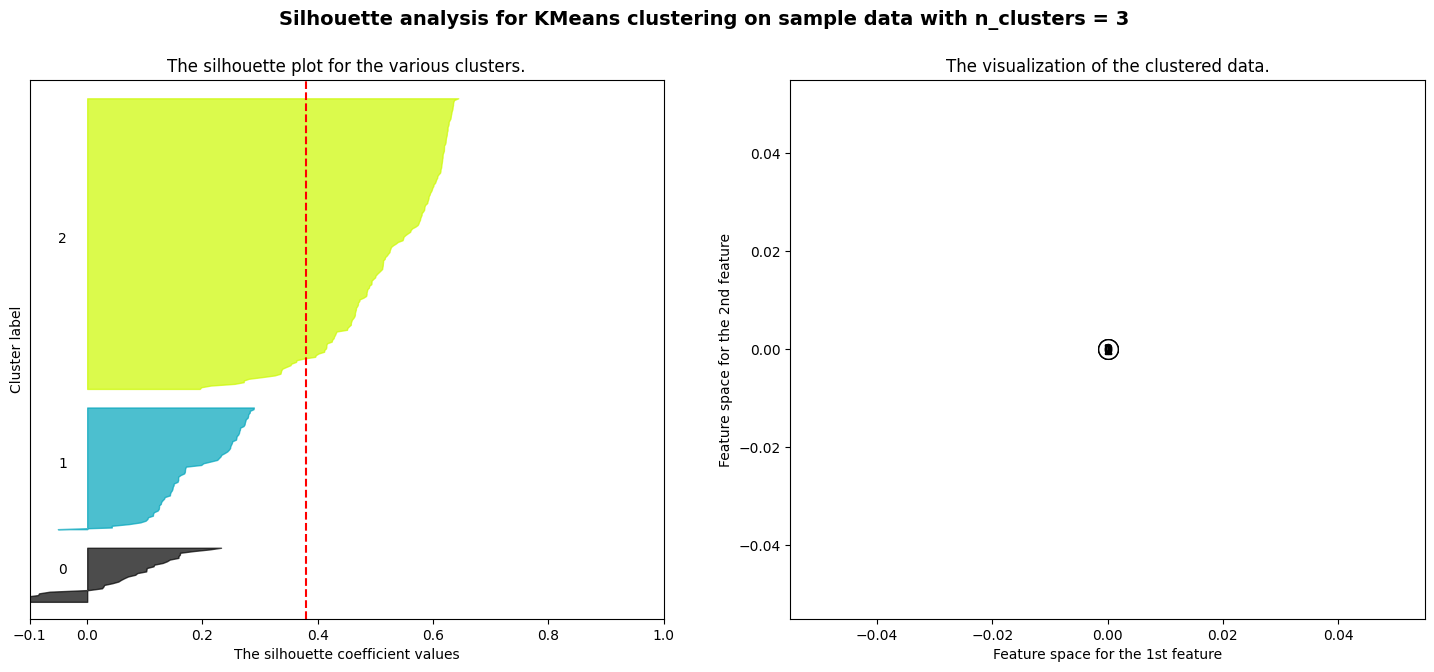

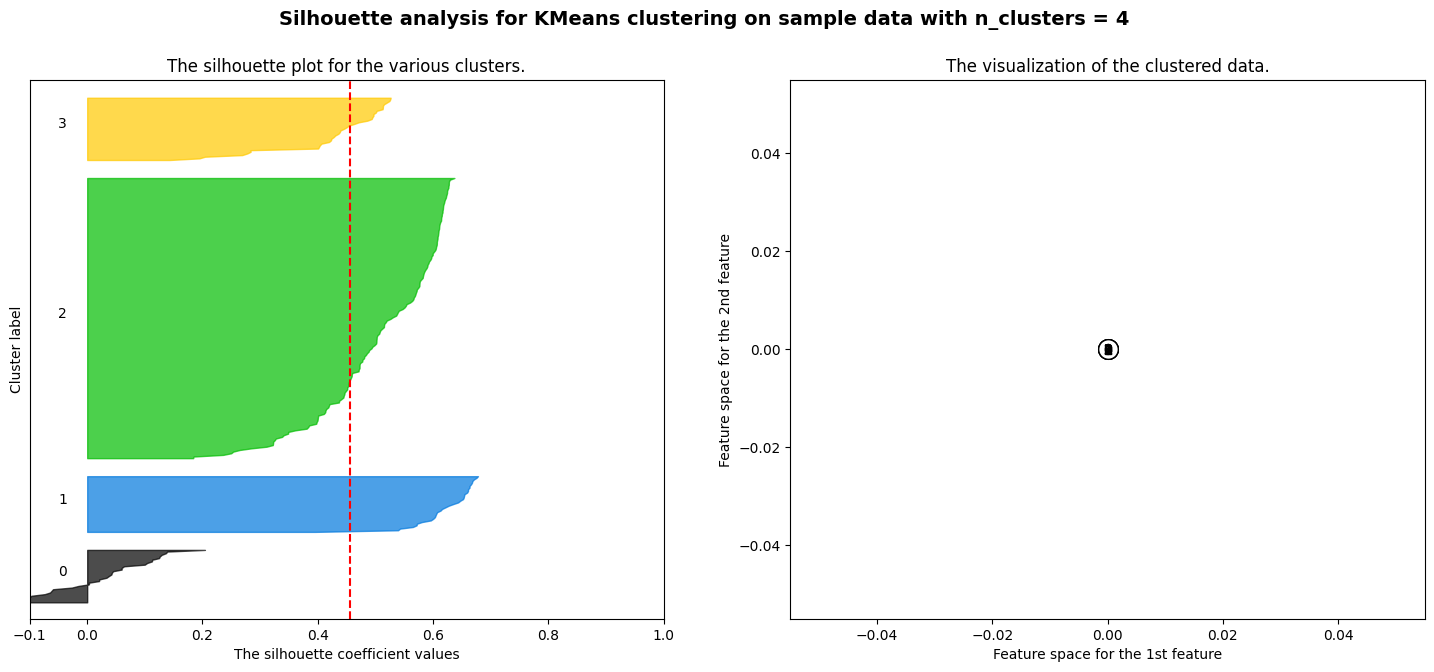

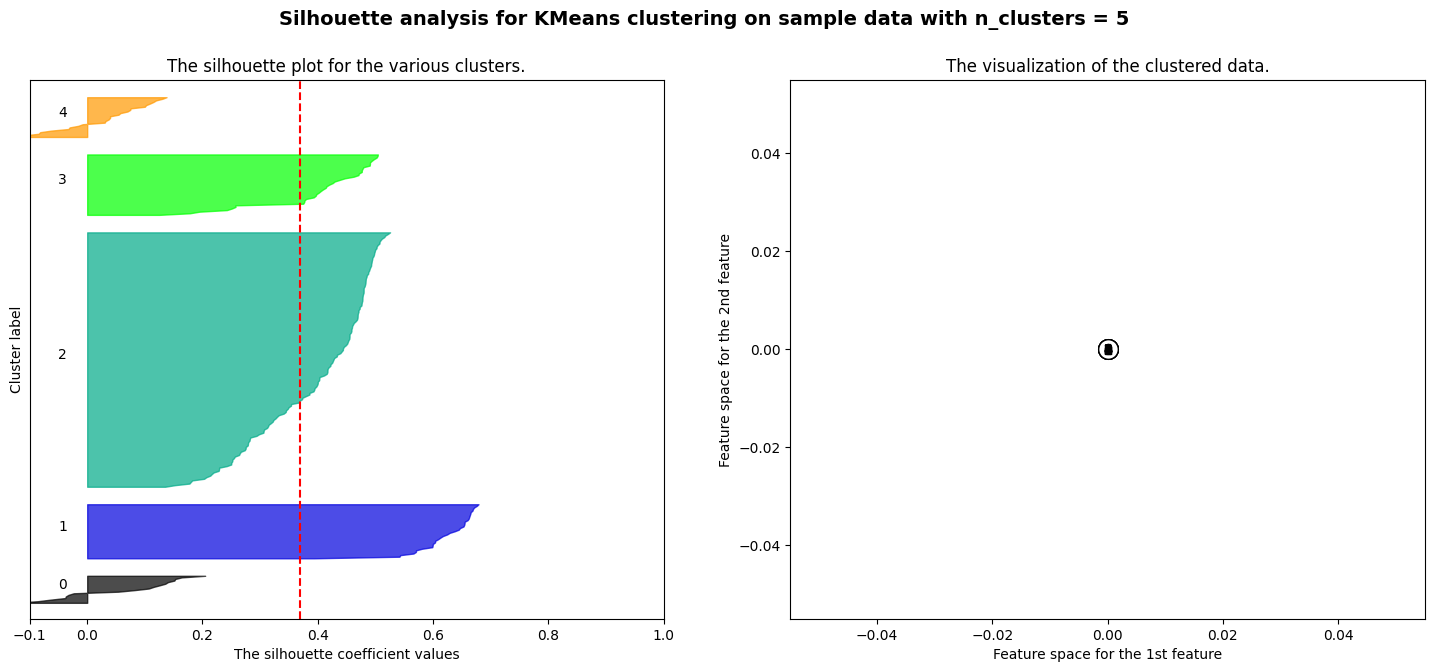

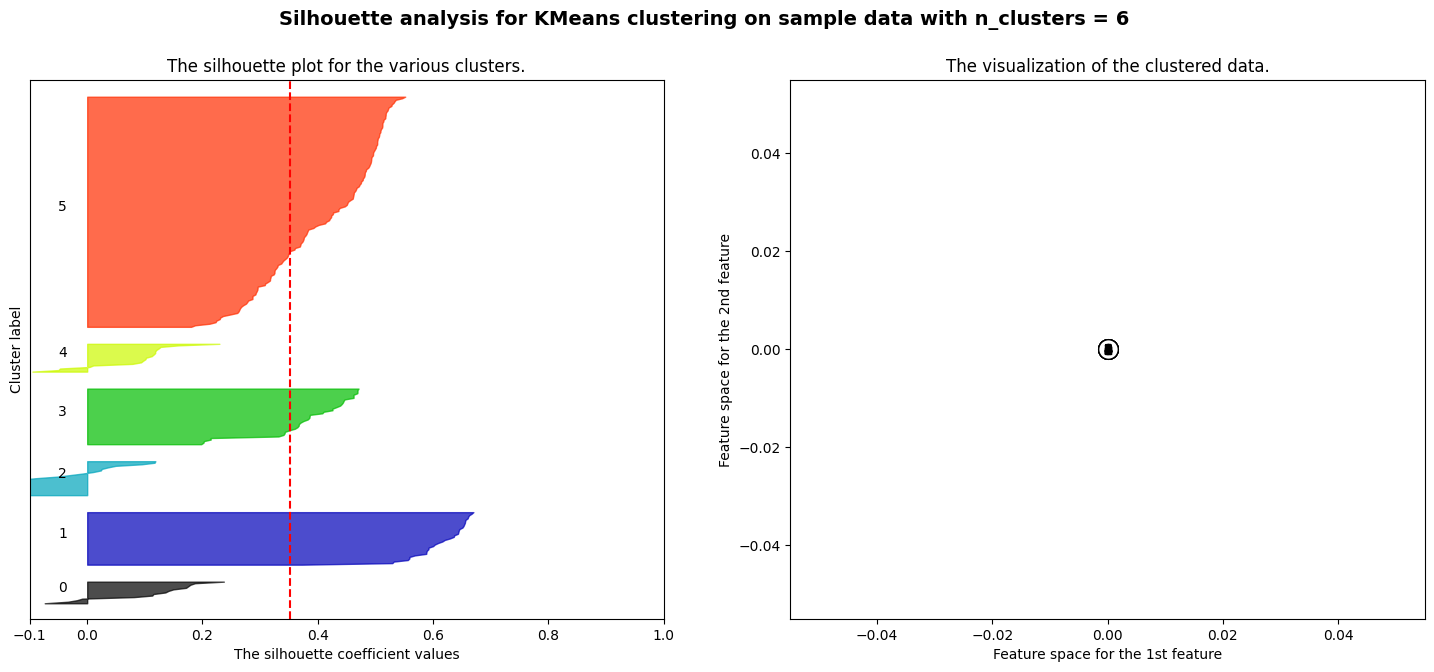

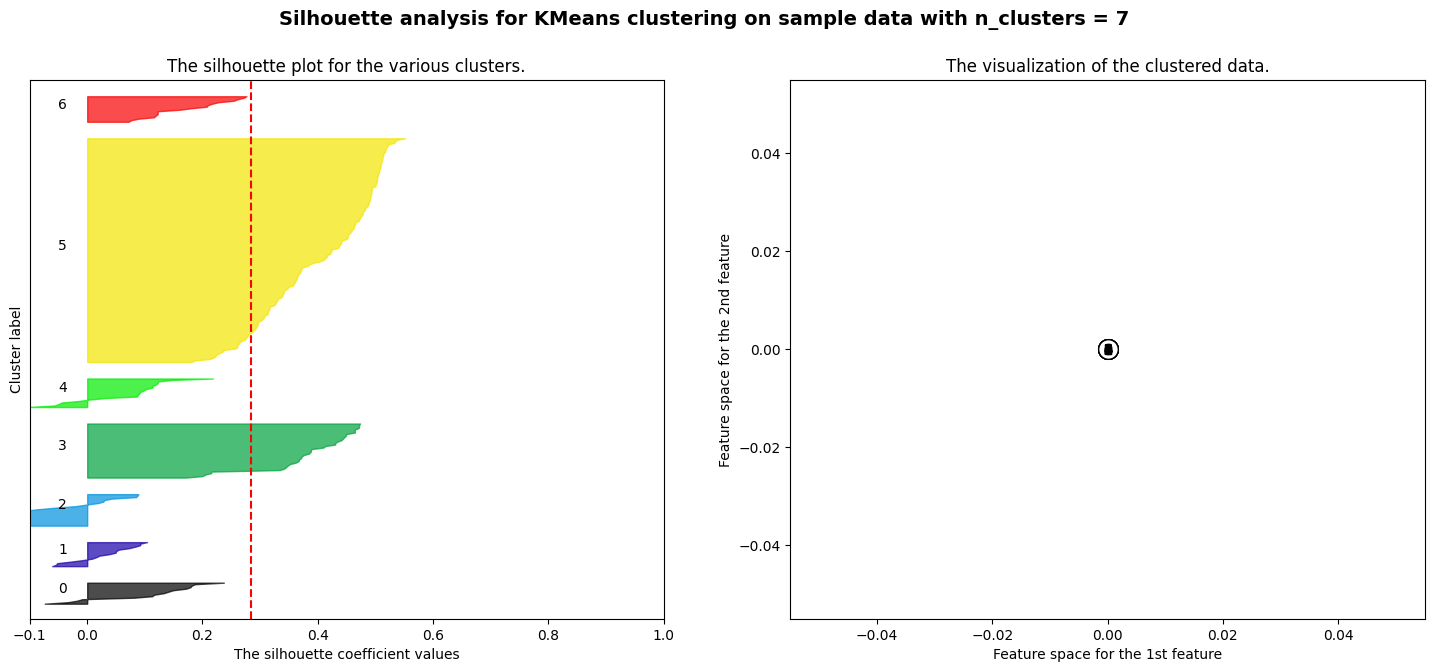

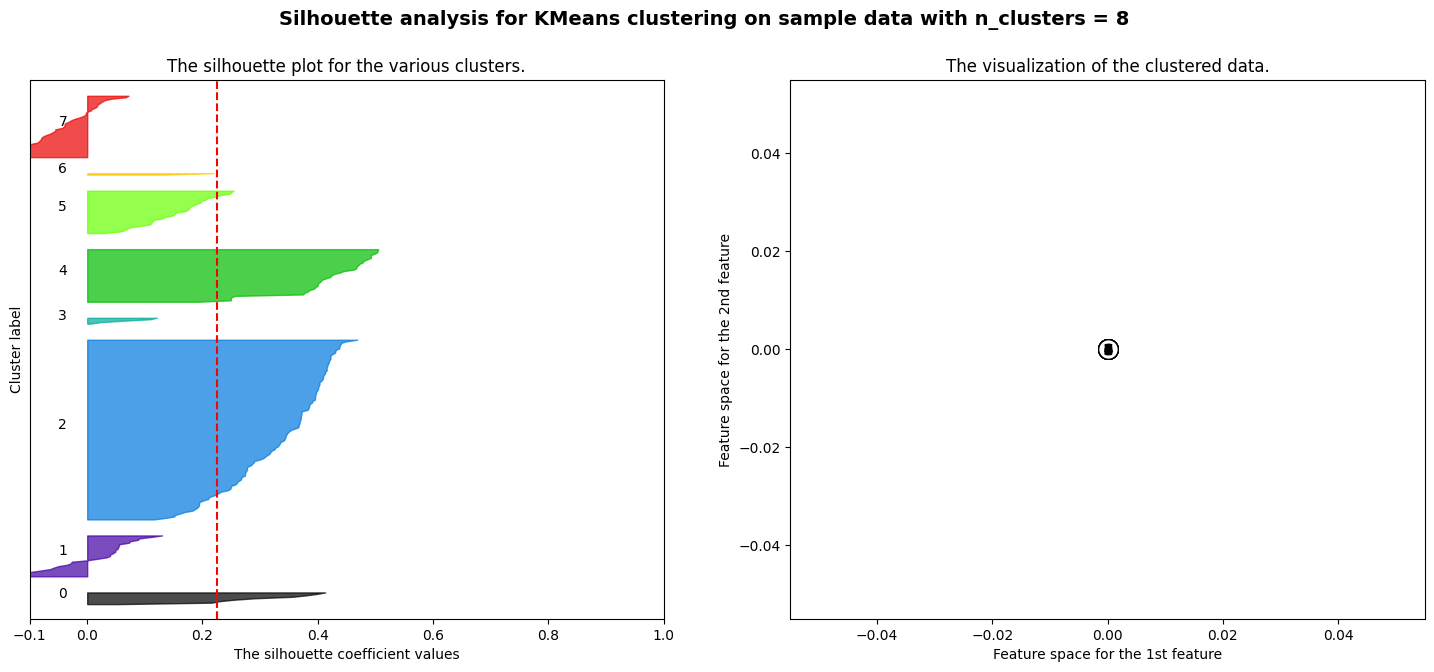

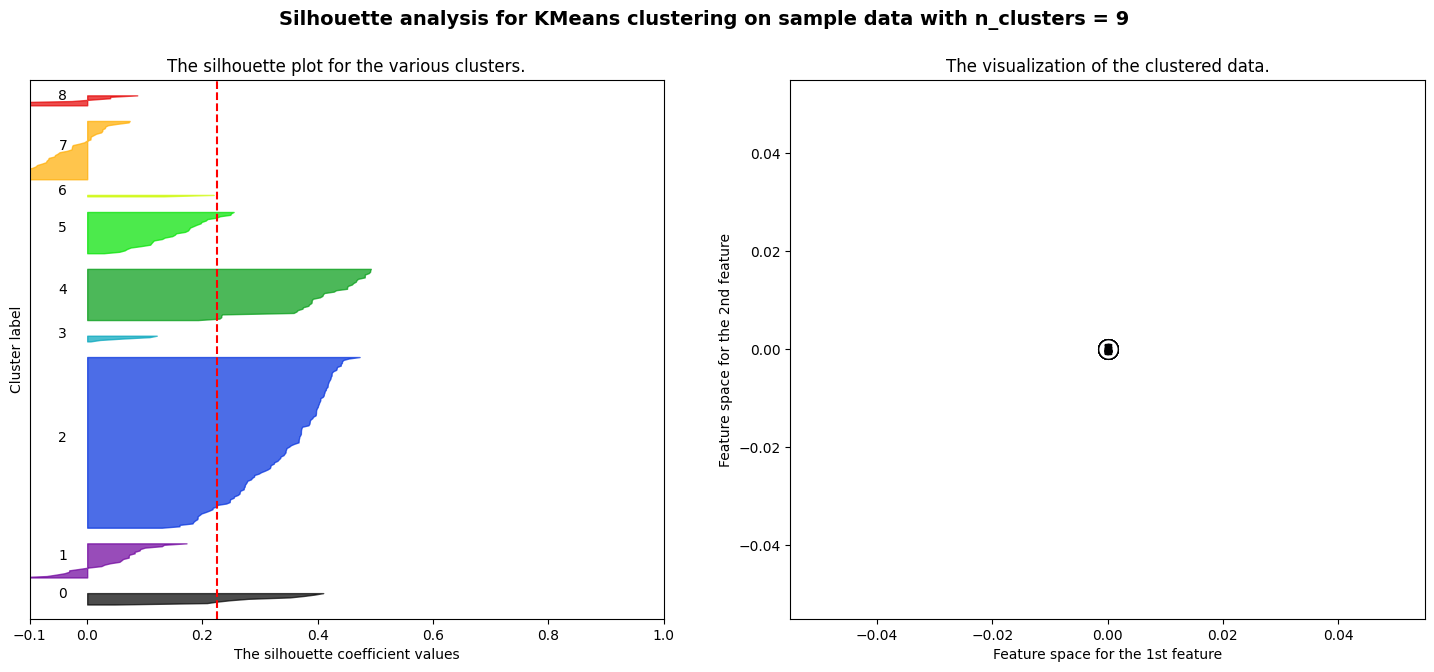

In [ ]:
X = np.array(latent_features1d)
K = range(3,10)

for n_clusters in tqdm(K):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=RANDOMSTATE)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

- The Silhouette score isn't significant for any cluster since its close to 0 for every k, that translates to less differentiability for a point to belong to a particular cluster.
- GMM can help in this case because animals share a lot of similar traits with each other in terms of appearance but we have to get the bottleneck case since an animal can only belong to one cluster, so kmeans will be the way to go but a different feature/keypoint detection might help identify right number of clusters.

## Using SIFT/SURF/ORB technique

In [ ]:
def build_dictionary(xfeatures2d, images, n_clusters):
    #print('Computing descriptors..')
    desc_list = []

    for image_path in images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, dsc = xfeatures2d.detectAndCompute(gray, None)
        desc_list.extend(dsc)

    desc = np.array(desc_list)
    #print('Creating BoW dictionary using K-Means clustering with k={}..'.format(n_clusters))
    dictionary = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, verbose=0)
    dictionary.fit(desc)

    distortion = sum(np.min(cdist(desc, dictionary.cluster_centers_,
                      'euclidean'),axis=1)) / desc.shape[0]

    return distortion

In [ ]:
orb = cv2.ORB_create()
images = df.image.values
K = range(4,10)
distortions = []

for k in tqdm(K):
    distortions.append(build_dictionary(orb, images, n_clusters=k))

  0%|          | 0/6 [00:04<?, ?it/s]


TypeError: 'NoneType' object is not iterable

In [ ]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

- The ORB technique tells us there are 6/7 major clusters that are persistent in the data